In [17]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) 

### 제주특별자치도_품종별감귤생산현황

In [18]:
url = "https://api.odcloud.kr/api/15010584/v1/uddi:eba2a3ef-a809-4516-854b-94a342fd2af1"
serviceKey = "API_KEY"

final_url = f"{url}?page=1&perPage=100&returnType=json&serviceKey={serviceKey}"

res = requests.get(final_url)
data = res.json()

In [19]:
records = data["data"]

df = pd.DataFrame(records)

num_cols = ['노지 만감류','노지 온주밀감','월동 온주밀감','하우스 만감류','하우스 온주밀감']
for col in num_cols:
    df[col] = df[col].astype(float)

df_pivot = df.pivot(index="연도별", columns="구분", values=num_cols)

df_pivot.columns = [f"{col}_{gubun}" for col, gubun in df_pivot.columns]

df_pivot = df_pivot.reset_index().sort_values("연도별")

In [20]:
for kind in ["노지 만감류", "노지 온주밀감", "월동 온주밀감", "하우스 만감류", "하우스 온주밀감"]:
    df_pivot[f"{kind}_생산성(톤/ha)"] = (
        df_pivot[f"{kind}_생산량(톤)"] / df_pivot[f"{kind}_면적(ha)"]
    )

df_productivity = df_pivot[["연도별"] + [col for col in df_pivot.columns if "생산성" in col]]

In [21]:
df_productivity

,연도별,노지 만감류_생산성(톤/ha),노지 온주밀감_생산성(톤/ha),월동 온주밀감_생산성(톤/ha),하우스 만감류_생산성(톤/ha),하우스 온주밀감_생산성(톤/ha)
0,2000,6.014085,21.381270,20.917492,17.154882,48.774250
1,2005,8.318739,31.463594,28.853093,16.862037,58.113531
2,2010,12.824324,26.816046,28.890392,25.743530,69.170669
3,2011,10.608108,28.373199,23.135919,26.014446,73.972185
4,2012,15.633929,32.143424,32.578497,30.554039,70.045614
5,2013,18.054348,32.275386,28.407195,33.952044,74.637405
6,2014,20.804124,33.849360,27.132075,32.928240,84.592157
7,2015,22.121212,30.953383,20.189033,32.397417,81.604000
8,2016,23.444553,28.104914,27.875477,33.127692,76.267606
9,2017,5.370703,29.338531,38.859046,23.054245,75.205980


### 제주특별자치도_식량작물생산현황

In [22]:
serviceKey = "API_KEY"

def get_odcloud_data(endpoint, perPage=100):
    final_url = f"{endpoint}?page=1&perPage={perPage}&returnType=json&serviceKey={serviceKey}"
    res = requests.get(final_url)
    res.raise_for_status()
    data = res.json()
    return pd.DataFrame(data["data"])

url_old = "https://api.odcloud.kr/api/15056328/v1/uddi:af451094-9c3b-4b23-9cee-8b54035f945d_201907021054"
df_old = get_odcloud_data(url_old)

url_new = "https://api.odcloud.kr/api/15056328/v1/uddi:06b0f6ea-4e45-4421-9a13-bfef16dea4ed"
df_new = get_odcloud_data(url_new)

In [23]:
def process_old(df_old):
    df_long = df_old.melt(
        id_vars=["작물별","구분","데이터기준일자"],
        var_name="연도",
        value_name="값"
    )
    df_long["연도"] = df_long["연도"].str.replace("년","").astype(int)
    df_long["값"] = pd.to_numeric(df_long["값"], errors="coerce")
    return df_long[["연도","작물별","구분","값"]]

df_old_long = process_old(df_old)

def process_new(df_new):
    drop_cols = ["관련부서","데이터기준일자","해당연도"]
    value_vars = [c for c in df_new.columns if c not in drop_cols + ["구분"]]

    df_long = df_new.melt(
        id_vars=["구분","해당연도"],
        value_vars=value_vars,
        var_name="작물별",
        value_name="값"
    )
    df_long.rename(columns={"해당연도":"연도"}, inplace=True)
    df_long["값"] = pd.to_numeric(df_long["값"], errors="coerce")
    return df_long[["연도","작물별","구분","값"]]

df_new_long = process_new(df_new)
df_all = pd.concat([df_old_long, df_new_long], ignore_index=True)

In [24]:
df_food_crop_production=df_all.copy()

In [25]:
df_food_crop_production

,연도,작물별,구분,값
0,2015,논벼,면적(ha),14
1,2015,논벼,생산량(톤),70
2,2015,밭벼,면적(ha),188
3,2015,밭벼,생산량(톤),561
4,2015,쌀보리,면적(ha),156
...,...,...,...,...
331,2021,팥,생산량 (톤),5
332,2022,팥,면적 (ha),6
333,2022,팥,생산량 (톤),6
334,2023,팥,면적 (ha),6


### 기상 데이터

In [26]:
from io import StringIO

AUTH_KEY = "API_KEY"
STN = 184  
all_data = []

for YEAR in range(2015, 2024):
    START = f"{YEAR}0101"
    END = f"{YEAR}1231"

    url = "https://apihub.kma.go.kr/api/typ01/url/kma_sfcdd3.php"
    params = {
        "tm1": START,
        "tm2": END,
        "stn": STN,
        "authKey": AUTH_KEY,
        "help": 0
    }

    res = requests.get(url, params=params)
    res.encoding = "utf-8"

    data_lines = [line for line in res.text.splitlines() if not line.startswith("#")]
    df_yearly = pd.read_csv(StringIO("\n".join(data_lines)), sep=r"\s+")

    df_yearly.columns = [
        "TM", "STN", "RN_DAY", "CA_TOT", "WS_AVG", "WR_DAY", "WD_MAX", "WS_MAX",
        "WS_MAX_TM", "WD_INS", "WS_INS", "WS_INS_TM", "TA_AVG", "TA_MAX", "TA_MAX_TM",
        "TA_MIN", "TA_MIN_TM", "TD_AVG", "TS_AVG", "TG_MIN", "HM_AVG", "HM_MIN",
        "HM_MIN_TM", "PV_AVG", "EV_S", "EV_L", "FG_DUR", "PA_AVG", "PS_AVG", "PS_MAX",
        "PS_MAX_TM", "PS_MIN", "PS_MIN_TM", "SS_DAY", "SS_DUR", "SS_CMB", "SI_DAY",
        "RN_D99", "RN_DUR", "SD_NEW", "SD_NEW_TM", "SD_MAX", "SD_MAX_TM",
        "TE_05", "TE_10", "TE_15", "TE_30", "TE_50",
        "SI_60M_MAX", "SI_60M_MAX_TM", "RN_60M_MAX", "RN_60M_MAX_TM",
        "RN_10M_MAX", "RN_10M_MAX_TM", "RN_POW_MAX", "RN_POW_MAX_TM"
    ]

    df_yearly["TM"] = pd.to_datetime(df_yearly["TM"], format="%Y%m%d")

    all_data.append(df_yearly)

df = pd.concat(all_data, ignore_index=True)

df_year = df.resample("YE", on="TM").agg({
    "TA_AVG": "mean",      # 연평균기온
    "TA_MAX": "max",       # 최고기온
    "TA_MIN": "min",       # 최저기온
    "RN_DAY": "sum",       # 연강수량
    "SS_DAY": "sum",       # 연일조시간
    "SI_DAY": "sum",       # 연일사합
    "HM_AVG": "mean",      # 평균습도
    "WS_AVG": "mean",      # 평균풍속
    "WS_MAX": "max"        # 최대풍속
})

df_year["year"] = df_year.index.year
df_year.reset_index(drop=True, inplace=True)

In [27]:
df_weather=df_year.copy()

### 생산/소비 데이터

In [28]:
file_vegetable = "data/vegetable_comsumption.csv"
file_fruit_export = "data/fruit_export.csv"
file_fruit_consumption = "data/fruit_consumption.csv"

df_vegetable_consumption = pd.read_csv(file_vegetable)
df_fruit_export = pd.read_csv(file_fruit_export)
df_fruit_consumption = pd.read_csv(file_fruit_consumption)

### 귤 생산량 데이터

In [29]:
file_tangerine= "data/tangerine.csv"

df_tangerine = pd.read_csv(file_tangerine)

### 데이터셋 통합

In [30]:
df_productivity.columns

Index(['연도별', '노지 만감류_생산성(톤/ha)', '노지 온주밀감_생산성(톤/ha)', '월동 온주밀감_생산성(톤/ha)',
       '하우스 만감류_생산성(톤/ha)', '하우스 온주밀감_생산성(톤/ha)'],
      dtype='object')

In [31]:
df_weather.columns

Index(['TA_AVG', 'TA_MAX', 'TA_MIN', 'RN_DAY', 'SS_DAY', 'SI_DAY', 'HM_AVG',
       'WS_AVG', 'WS_MAX', 'year'],
      dtype='object')

In [32]:
df_vegetable_consumption.columns

Index(['연도', '계', '무', '배추', '마늘', '양파', '고추', '기타'], dtype='object')

In [33]:
df_fruit_export.columns

Index(['연도', '합계', '사과', '배', '복숭아', '감귤', '기타', '냉동과실', '조제과실', '과실주스'], dtype='object')

In [34]:
df_fruit_consumption.columns

Index(['연도', '합계', '사과', '배', '복숭아', '포도', '단감', '감귤', '기타'], dtype='object')

In [35]:
df_tangerine.columns

Index(['년도', '감귤_면적(천ha)', '감귤_생산량(천t)'], dtype='object')

In [36]:
df_vegetable_consumption = df_vegetable_consumption.rename(
    columns={col: f"{col}_채소소비량" for col in df_vegetable_consumption.columns if col != "연도"}
)

df_fruit_consumption = df_fruit_consumption.rename(
    columns={col: f"{col}_과일소비량" for col in df_fruit_consumption.columns if col != "연도"}
)

df_fruit_export = df_fruit_export.rename(
    columns={col: f"{col}_과일수출량" for col in df_fruit_export.columns if col != "연도"}
)

In [37]:
df_productivity = df_productivity.rename(columns={"연도별": "year"})
df_vegetable_consumption = df_vegetable_consumption.rename(columns={"연도": "year"})
df_fruit_export = df_fruit_export.rename(columns={"연도": "year"})
df_fruit_consumption = df_fruit_consumption.rename(columns={"연도": "year"})
df_tangerine = df_tangerine.rename(columns={"년도" : "year"})

years = list(range(2015, 2024))

df_productivity = df_productivity[df_productivity["year"].isin(years)]
df_weather = df_weather[df_weather["year"].isin(years)]
df_vegetable_consumption = df_vegetable_consumption[df_vegetable_consumption["year"].isin(years)]
df_fruit_export = df_fruit_export[df_fruit_export["year"].isin(years)]
df_fruit_consumption = df_fruit_consumption[df_fruit_consumption["year"].isin(years)]
df_tangerine = df_tangerine[df_tangerine["year"].isin(years)]

from functools import reduce

dfs = [df_productivity, df_weather, df_vegetable_consumption, df_fruit_export, df_fruit_consumption, df_tangerine]

df_merged = reduce(lambda left, right: pd.merge(left, right, on="year", how="outer"), dfs)

df_merged = df_merged.sort_values("year").reset_index(drop=True)

In [38]:
df=df_merged.copy()

### 시각화

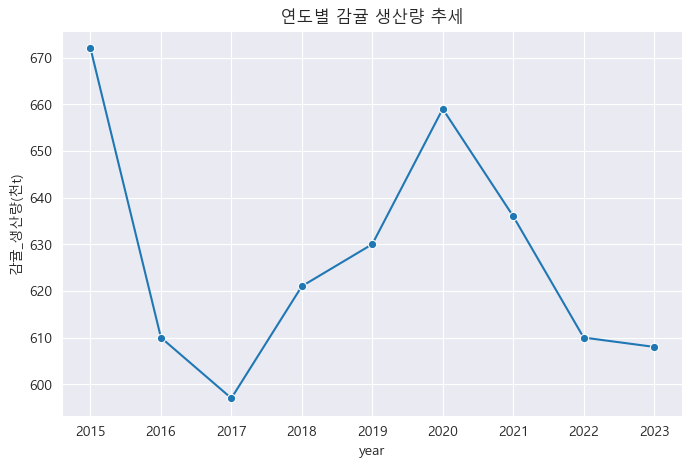

In [39]:
plt.figure(figsize=(8,5))
sns.lineplot(x="year", y="감귤_생산량(천t)", data=df, marker="o")
plt.title("연도별 감귤 생산량 추세")
plt.show()

In [40]:
productivity = [
    "노지 만감류_생산성(톤/ha)",
    "노지 온주밀감_생산성(톤/ha)",
    "월동 온주밀감_생산성(톤/ha)",
    "하우스 만감류_생산성(톤/ha)",
    "하우스 온주밀감_생산성(톤/ha)"
]

weather = [
    "TA_AVG","TA_MAX","TA_MIN",
    "RN_DAY","SS_DAY","SI_DAY",
    "HM_AVG","WS_AVG","WS_MAX"
]

vegetable_consumption = [
    "계_채소소비량","무_채소소비량","배추_채소소비량",
    "마늘_채소소비량","양파_채소소비량","고추_채소소비량",
    "기타_채소소비량"
]

fruit_export = [
    "합계_과일수출량","사과_과일수출량","배_과일수출량",
    "복숭아_과일수출량","감귤_과일수출량","기타_과일수출량",
    "냉동과실_과일수출량","조제과실_과일수출량","과실주스_과일수출량"
]

fruit_consumption = [
    "합계_과일소비량","사과_과일소비량","배_과일소비량",
    "복숭아_과일소비량","포도_과일소비량","단감_과일소비량",
    "감귤_과일소비량","기타_과일소비량"
]

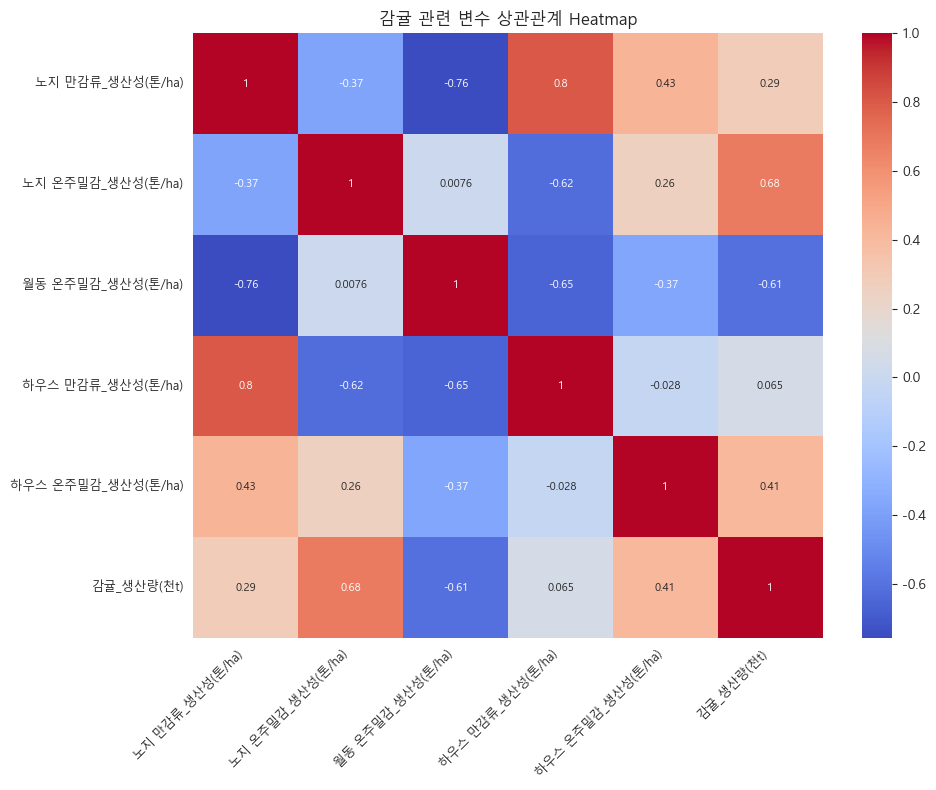

In [41]:
cols = productivity.copy()
cols.append("감귤_생산량(천t)")

plt.figure(figsize=(10,8))

sns.heatmap(
    df[cols].corr(),
    annot=True,
    cmap="coolwarm",
    annot_kws={"size":8}
)

plt.xticks(fontsize=9, rotation=45, ha="right")
plt.yticks(fontsize=9)
plt.title("감귤 관련 변수 상관관계 Heatmap", fontsize=12)

plt.tight_layout()
plt.show()

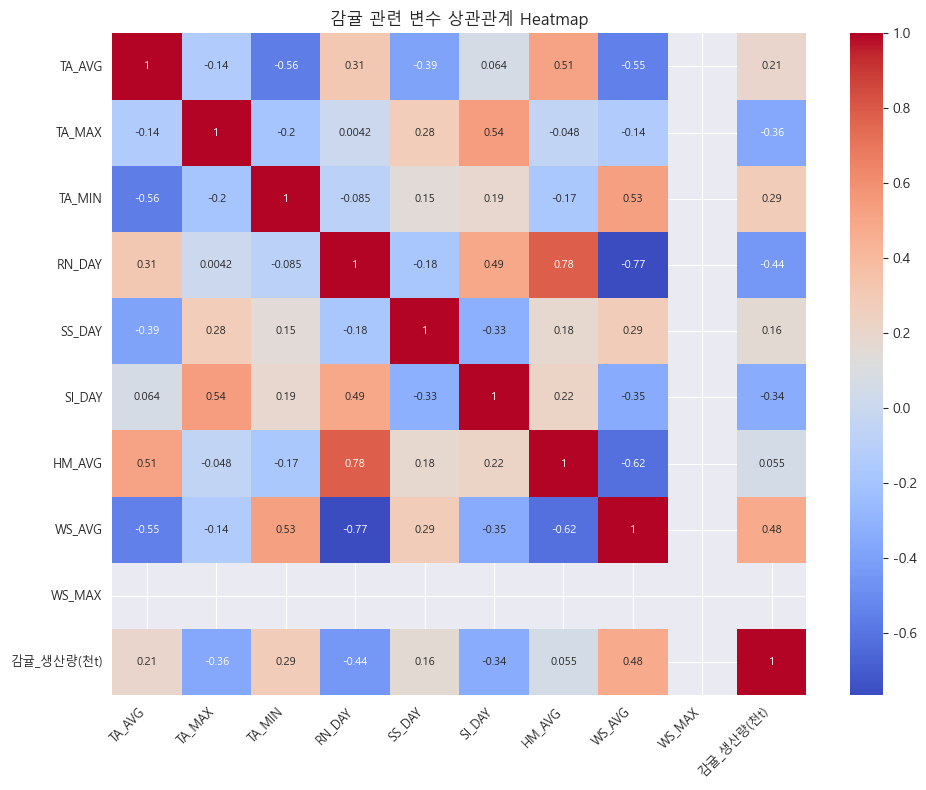

In [42]:
cols = weather.copy()
cols.append("감귤_생산량(천t)")

plt.figure(figsize=(10,8))

sns.heatmap(
    df[cols].corr(),
    annot=True,
    cmap="coolwarm",
    annot_kws={"size":8}
)

plt.xticks(fontsize=9, rotation=45, ha="right")
plt.yticks(fontsize=9)
plt.title("감귤 관련 변수 상관관계 Heatmap", fontsize=12)

plt.tight_layout()
plt.show()

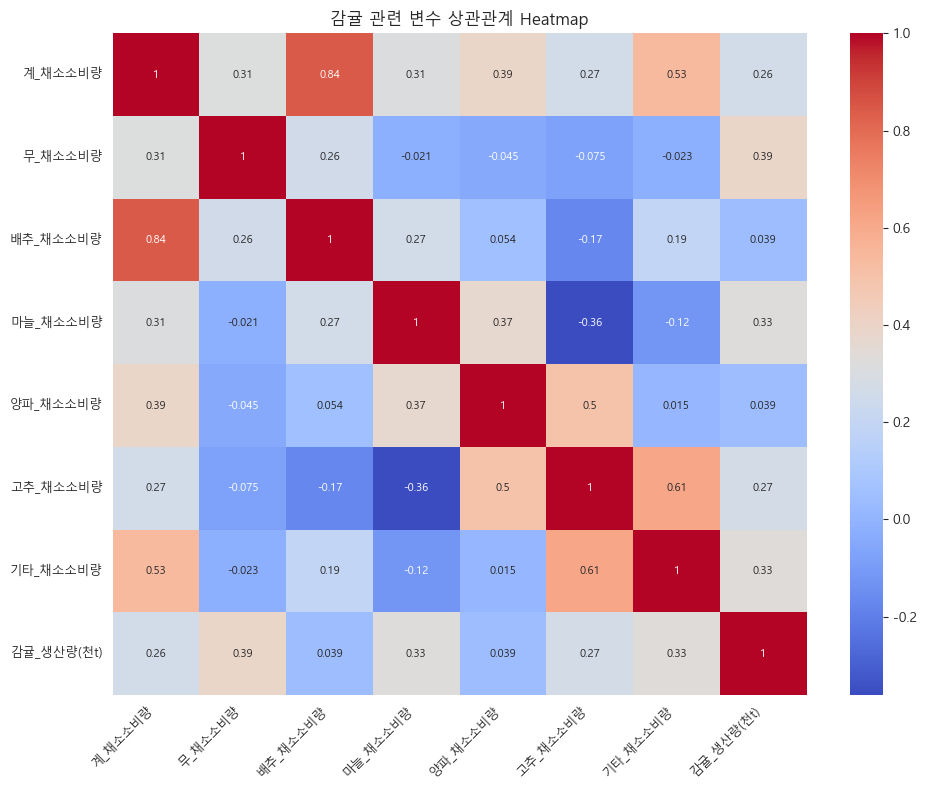

In [43]:
cols = vegetable_consumption.copy()
cols.append("감귤_생산량(천t)")

plt.figure(figsize=(10,8))

sns.heatmap(
    df[cols].corr(),
    annot=True,
    cmap="coolwarm",
    annot_kws={"size":8}
)

plt.xticks(fontsize=9, rotation=45, ha="right")
plt.yticks(fontsize=9)
plt.title("감귤 관련 변수 상관관계 Heatmap", fontsize=12)

plt.tight_layout()
plt.show()

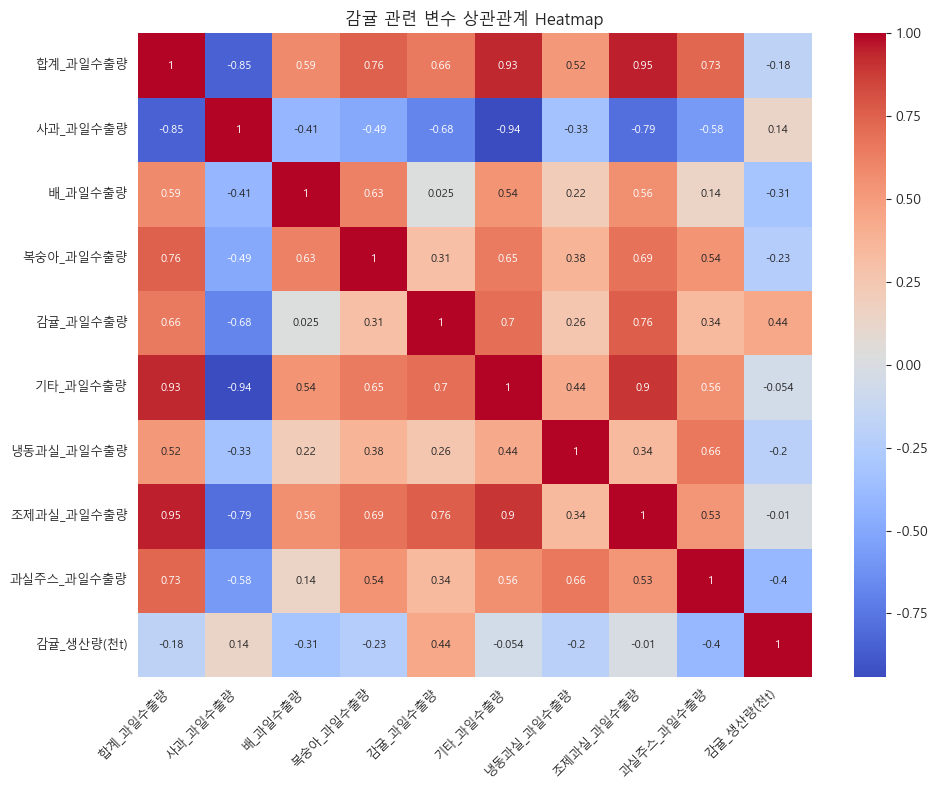

In [44]:
cols = fruit_export.copy()
cols.append("감귤_생산량(천t)")

plt.figure(figsize=(10,8))

sns.heatmap(
    df[cols].corr(),
    annot=True,
    cmap="coolwarm",
    annot_kws={"size":8}
)

plt.xticks(fontsize=9, rotation=45, ha="right")
plt.yticks(fontsize=9)
plt.title("감귤 관련 변수 상관관계 Heatmap", fontsize=12)

plt.tight_layout()
plt.show()

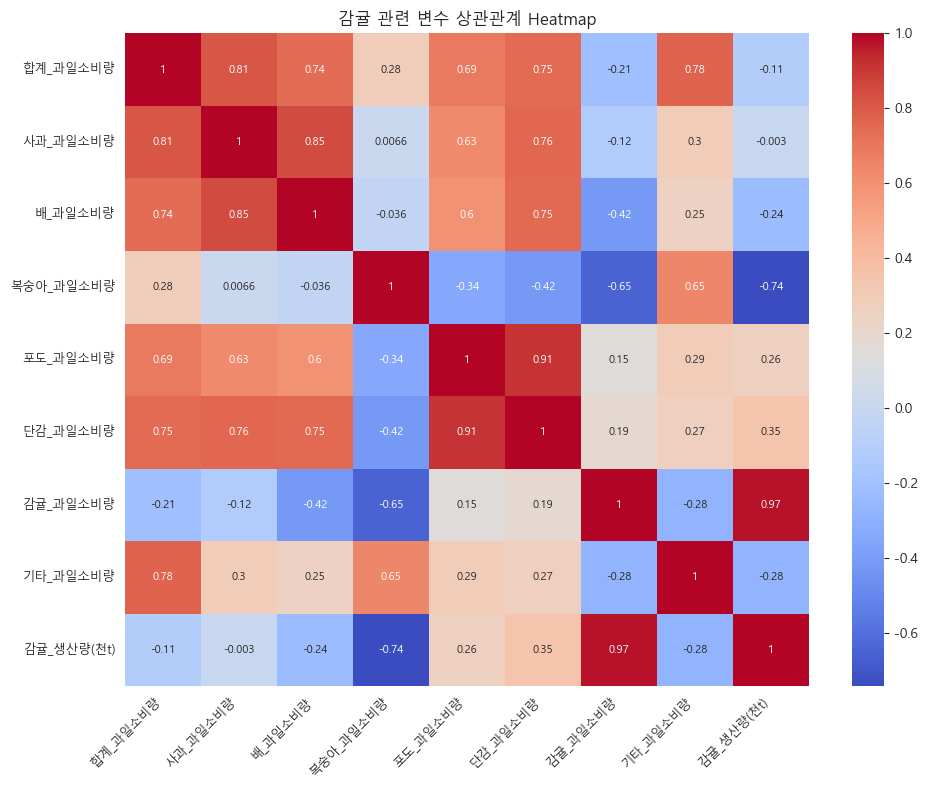

In [45]:
cols = fruit_consumption.copy()
cols.append("감귤_생산량(천t)")

plt.figure(figsize=(10,8))

sns.heatmap(
    df[cols].corr(),
    annot=True,
    cmap="coolwarm",
    annot_kws={"size":8}
)

plt.xticks(fontsize=9, rotation=45, ha="right")
plt.yticks(fontsize=9)
plt.title("감귤 관련 변수 상관관계 Heatmap", fontsize=12)

plt.tight_layout()
plt.show()

In [57]:
target = "감귤_생산량(천t)"

corr = df.corr()[target].drop(target)

selected = corr[abs(corr) > 0.4].sort_values(ascending=False)

print(selected)

감귤_과일소비량              0.972799
노지 온주밀감_생산성(톤/ha)     0.678892
WS_AVG                0.481550
감귤_과일수출량              0.440613
하우스 온주밀감_생산성(톤/ha)    0.414892
과실주스_과일수출량           -0.401360
RN_DAY               -0.443860
월동 온주밀감_생산성(톤/ha)    -0.611477
복숭아_과일소비량            -0.742268
감귤_면적(천ha)           -0.798882
Name: 감귤_생산량(천t), dtype: float64


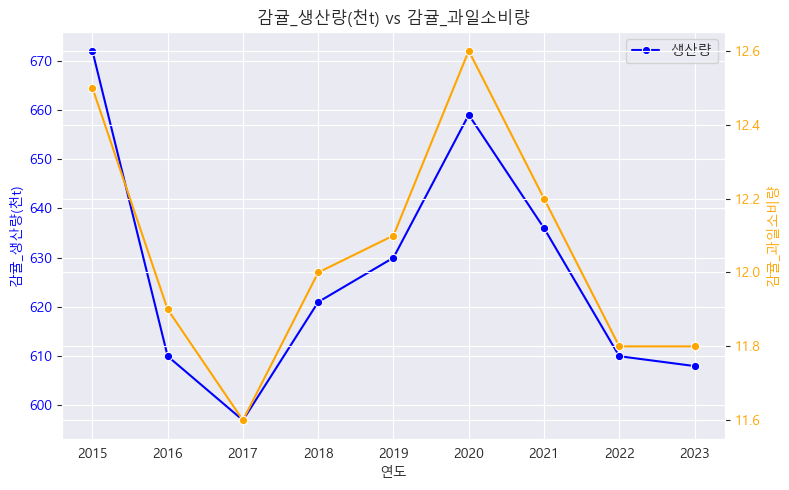

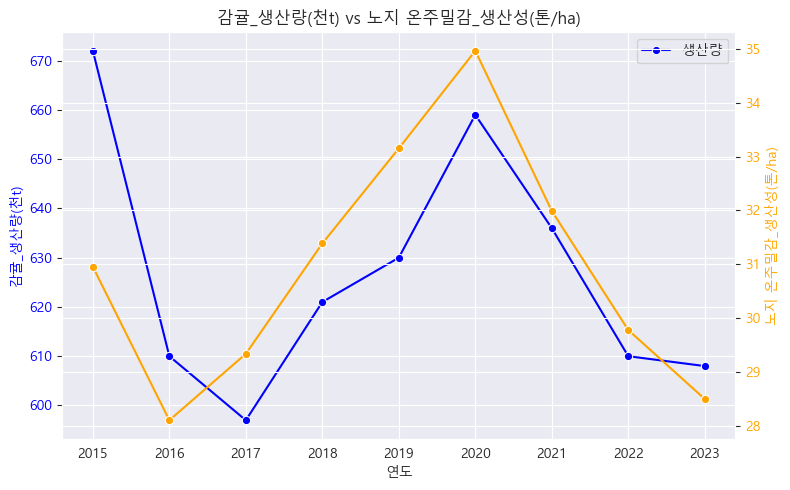

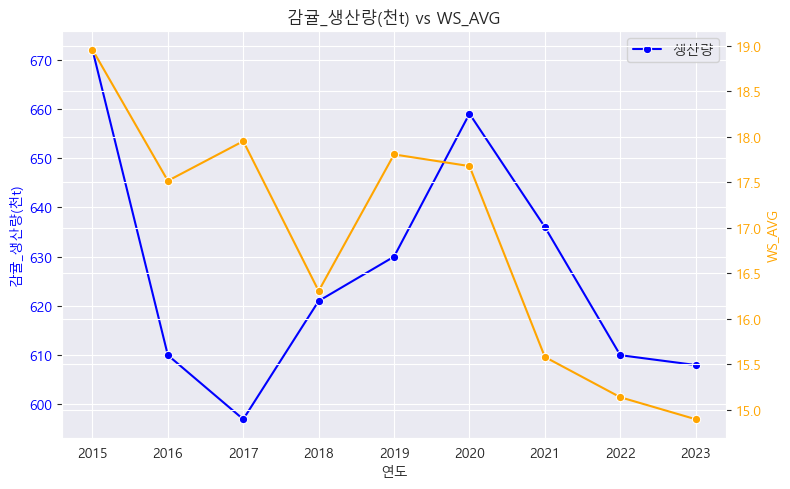

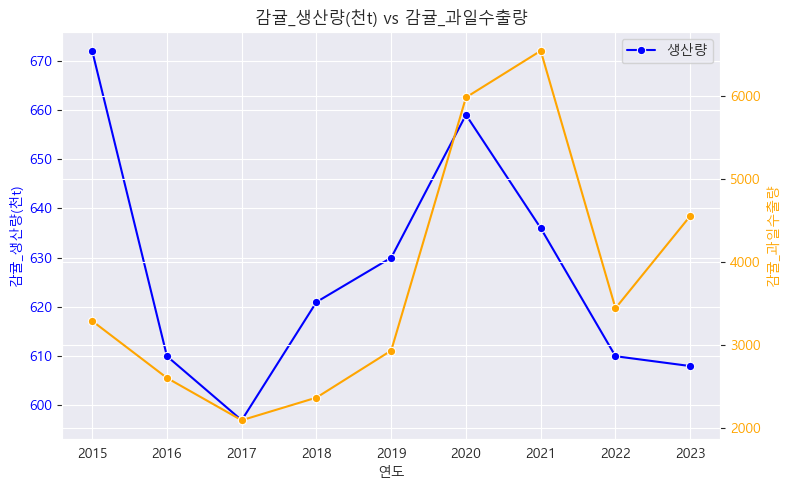

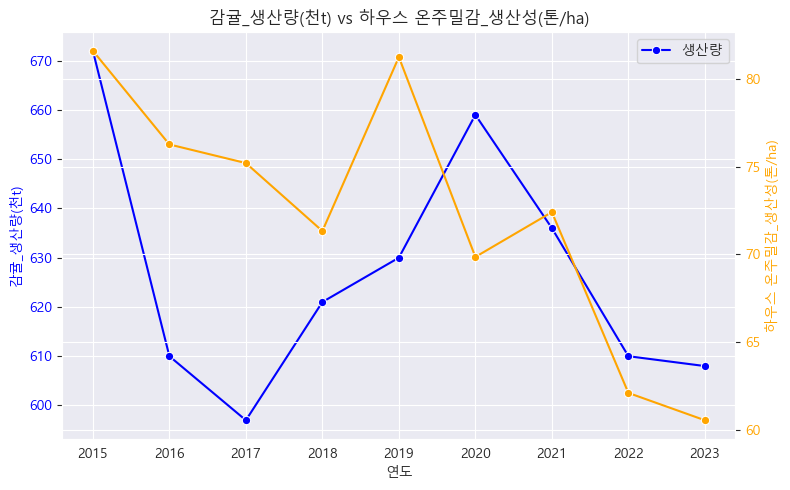

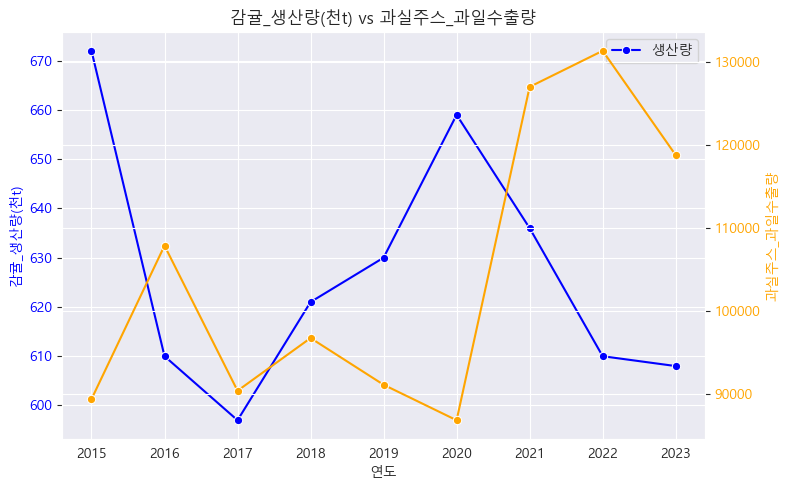

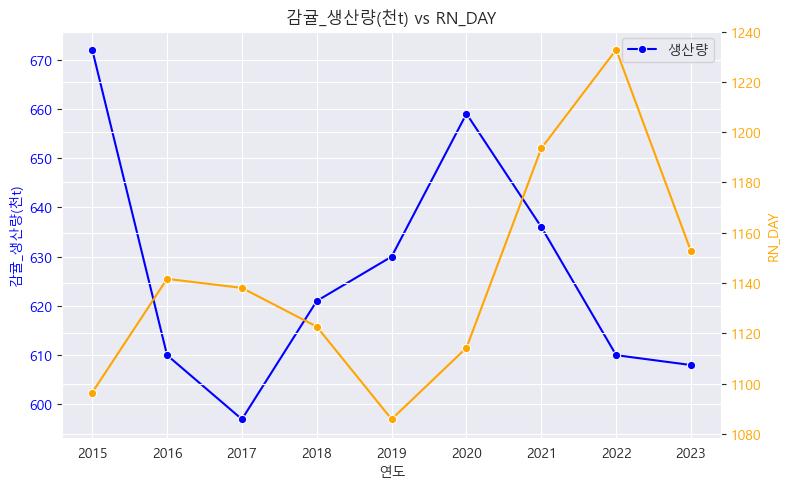

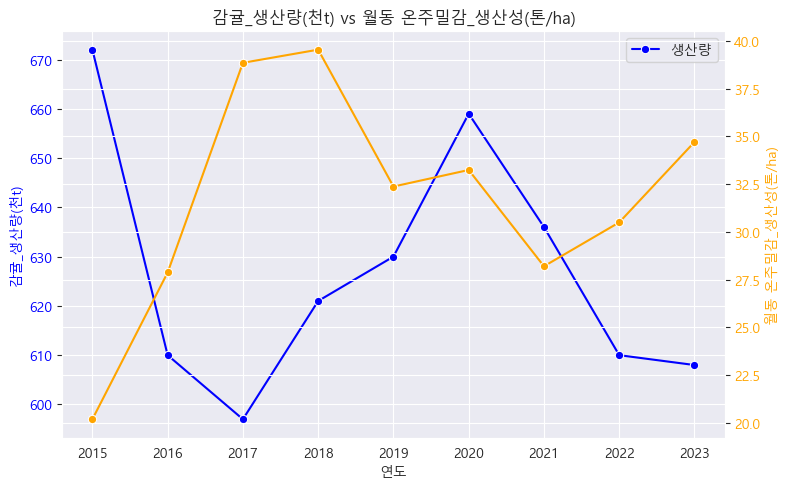

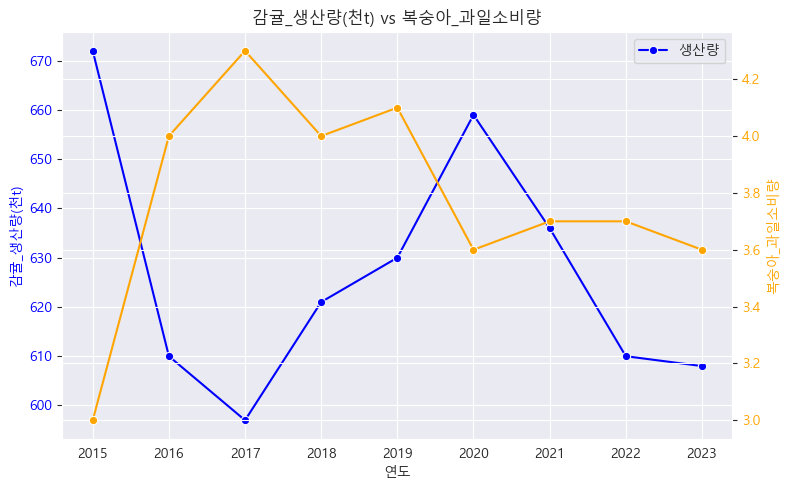

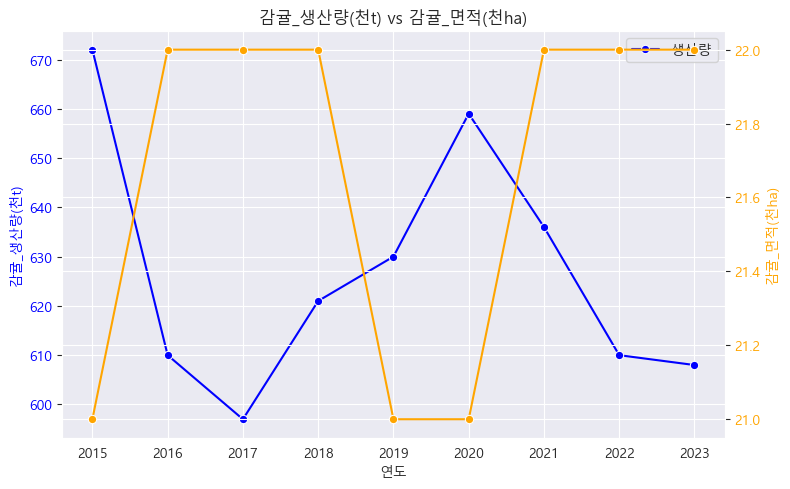

In [60]:
x="감귤_생산량(천t)"

for y in selected.index.tolist():
    fig, ax1 = plt.subplots(figsize=(8,5))

    ax1.set_xlabel("연도")
    ax1.set_ylabel(x, color="blue")
    sns.lineplot(x="year", y=x, data=df, marker="o", color="blue", ax=ax1, label="생산량")
    ax1.tick_params(axis="y", labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel(y, color="orange")
    sns.lineplot(x="year", y=y, data=df, marker="o", color="orange", ax=ax2)
    ax2.tick_params(axis="y", labelcolor="orange")

    plt.title(f"{x} vs {y}")
    fig.tight_layout()
    plt.show()

### Model

In [58]:
X = df[selected.index.tolist()]
y = df["감귤_생산량(천t)"]

X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

coeffs = model.params.to_dict()
print("what-if용 회귀계수:\n", coeffs)

what-if용 회귀계수:
 {'const': 2.625250871672329, '감귤_과일소비량': 18.548356714914902, '노지 온주밀감_생산성(톤/ha)': 6.340148975053342, 'WS_AVG': 9.506145364385503, '감귤_과일수출량': -0.0009609116874985356, '하우스 온주밀감_생산성(톤/ha)': 0.13114849779832138, '과실주스_과일수출량': 0.0007250232358434108, 'RN_DAY': -0.15796225429840638, '월동 온주밀감_생산성(톤/ha)': 0.4571769085408688, '복숭아_과일소비량': -42.16527122509427, '감귤_면적(천ha)': 13.296038440072467}
